# Imputation of missing values: `StartYear` and `StopYear`

I went through several classes in the `skikit-learn`, but the most explicit and optimal way (it seems to me) is to fill in  missing values by `mean` or `most frequent value` by group, based on `MentorType` and `ResaarchArea` variables. 

Steps:

1. Count `duration` as $StopYear - StartYear$. We have cases:
- `StartYear != NaN & StopYear != NaN`. Here `duration` is a number. We will count `mean`/`mfv` values on it (for next two cases).
- `StartYear == NaN | StopYear == NaN`. Here `duration == NaN`. We will imput it and find missing `StartYear` or `StopYear`.
- `StartYear == NaN & StopYear == NaN`.  Here `duration == NaN`. We will imput it but not find`StartYear` and `StopYear`.

2. For `duration` count `mean` or `most frequent value` by groups (`groupby(['MentorshipType','ResearchArea_m'])`). So we get `mean/mfv` separately for _graduate student in low_ separately for _postdoc in neiro_, etc.

3. Input `mean/mfv` for `duration == NaN`. For `StartYear == NaN & StopYear == NaN` case we stop here. 

4. Restore `StartYear` and `StopYear` for `StartYear == NaN | StopYear == NaN` case.




In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
pd.options.mode.chained_assignment
pd.options.mode.chained_assignment = None  # hide warnings about .loc

In [2]:
connect = pd.read_csv('~/datasets/s4/MENTORSHIP/mentorship.csv')
people = pd.read_csv('~/datasets/s4/MENTORSHIP/researcher.csv')

In [3]:
connect = connect[['CID','MenteeID','MentorID','MentorshipType','Institution','InstitutionMAGID','StartYear','StopYear']]
people = people[['PID','ResearchArea']]

In [4]:
connect_names = connect.merge(people[['PID','ResearchArea']], how='inner', left_on='MenteeID', right_on='PID')
connect_names = connect_names.merge(people[['PID','ResearchArea']], how='inner', left_on='MentorID', 
                                    right_on='PID', suffixes=['_t','_m'])

#connect_names.head()

## Imputation of missing values by `mean`

In [5]:
connect_names_input = connect_names[['MentorshipType','ResearchArea_m','StartYear','StopYear']]
connect_names_input.loc[connect_names_input.StartYear == -1, 'StartYear'] = np.nan
connect_names_input.loc[connect_names_input.StopYear == -1, 'StopYear'] = np.nan
connect_names_input['ResearchArea_m'] = connect_names_input['ResearchArea_m'].str.split(',').str[0]
connect_names_input['duration'] = connect_names_input['StopYear'] - connect_names_input['StartYear']

connect_names_input

,MentorshipType,ResearchArea_m,StartYear,StopYear,duration
0,1,neuro,2000.0,2005.0,5.0
1,2,neuro,2003.0,2006.0,3.0
2,1,neuro,2002.0,2008.0,6.0
3,1,neuro,NaN,NaN,NaN
4,2,neuro,NaN,NaN,NaN
...,...,...,...,...,...
743171,1,physics,1987.0,1991.0,4.0
743172,1,sociology,NaN,2015.0,NaN
743173,1,neuro,2016.0,2022.0,6.0
743174,1,evol,NaN,1983.0,NaN


In [6]:
connect_names_input['mean_group_duration'] = connect_names_input.groupby(['MentorshipType','ResearchArea_m'])['duration'].transform('mean')
connect_names_input['mean_group_duration'] = round(pd.to_numeric(connect_names_input['mean_group_duration'], errors='coerce'))

# If you need mfv, you can use next line instead of mean
#connect_names_input['mode_group_duration'] = connect_names_input.groupby(['MentorshipType','ResearchArea_m'])['duration'].transform(lambda x: pd.Series.mode(x)[0] if not x.isna().all() else np.nan)

connect_names_input.loc[connect_names_input['duration'].isnull(),'duration'] = connect_names_input['mean_group_duration']
connect_names_input.loc[connect_names_input['StartYear'].isnull() & connect_names_input['StopYear'].notnull(),'StartYear'] = connect_names_input['StopYear'] - connect_names_input['mean_group_duration']
connect_names_input.loc[connect_names_input['StopYear'].isnull() & connect_names_input['StartYear'].notnull(),'StopYear'] = connect_names_input['StartYear'] + connect_names_input['mean_group_duration']
connect_names_input

,MentorshipType,ResearchArea_m,StartYear,StopYear,duration,mean_group_duration
0,1,neuro,2000.0,2005.0,5.0,4.0
1,2,neuro,2003.0,2006.0,3.0,3.0
2,1,neuro,2002.0,2008.0,6.0,4.0
3,1,neuro,NaN,NaN,4.0,4.0
4,2,neuro,NaN,NaN,3.0,3.0
...,...,...,...,...,...,...
743171,1,physics,1987.0,1991.0,4.0,4.0
743172,1,sociology,2010.0,2015.0,5.0,5.0
743173,1,neuro,2016.0,2022.0,6.0,4.0
743174,1,evol,1979.0,1983.0,4.0,4.0


So, we have more of less ok `duration` for 99.8% rows (between 0 and 10 years, but also we have 0.02% junk like -900 years, because there are people, for example, with `StartYear == 2000` and `StopYear == 1100`). For `StartYear` and `StopYear` we still have 14% missing data:

In [7]:
connect_names_input.isna().sum()

MentorshipType              0
ResearchArea_m              0
StartYear              105019
StopYear               104996
duration                  236
mean_group_duration       236
dtype: int64

## Metodology notes: A quick look at values we will impute to missing values

In total we have 432 groups, grouped by `MentorshipType`,`ResearchArea_m`. Thus, for a particular _graduate student in neiro_, whose `duration` we do not know, we input  `mean/mfv duration` calculated for the group _graduate student in neiro_.

In [8]:
quick_look = connect_names[['MentorshipType','ResearchArea_m','StartYear','StopYear']]
quick_look.loc[quick_look.StartYear == -1, 'StartYear'] = np.nan
quick_look.loc[quick_look.StopYear == -1, 'StopYear'] = np.nan
quick_look['ResearchArea_m'] = quick_look['ResearchArea_m'].str.split(',').str[0]
quick_look['duration'] = quick_look['StopYear'] - quick_look['StartYear']

quick_look = quick_look[['MentorshipType','ResearchArea_m','duration']]

quick_look = quick_look.groupby(['MentorshipType','ResearchArea_m']) \
    .agg(n =('duration',len),
         NaN_count = ('duration', lambda x: x.isnull().sum()),  
         mean_group_duration = ('duration','mean'), 
         #median_group_duration =('duration','median'),
         mfv_group_duration  = ('duration', lambda x: pd.Series.mode(x)[0] if not x.isna().all() else np.nan)) \
    .reset_index() \
  .sort_values(by=['n'], ascending=False).astype({"n": int, "NaN_count": int})

quick_look['mean_group_duration'] = round(pd.to_numeric(quick_look['mean_group_duration'], errors='coerce'))

quick_look

,MentorshipType,ResearchArea_m,n,NaN_count,mean_group_duration,mfv_group_duration
140,1,neuro,109165,88049,4.0,5.0
97,1,chemistry,89139,73366,4.0,5.0
109,1,educ,49606,49458,4.0,5.0
154,1,physics,44249,38621,4.0,4.0
112,1,etree,43045,41470,5.0,5.0
...,...,...,...,...,...,...
119,1,grouprelations,1,1,NaN,NaN
108,1,ecotox,1,1,NaN,NaN
386,4,marinemammalscience,1,1,NaN,NaN
390,4,mich,1,1,NaN,NaN


There is no simple answer as to whether `mean` or `mfv` is better. You can see on the graph that for many areas these values are the same, and for some areas are not.

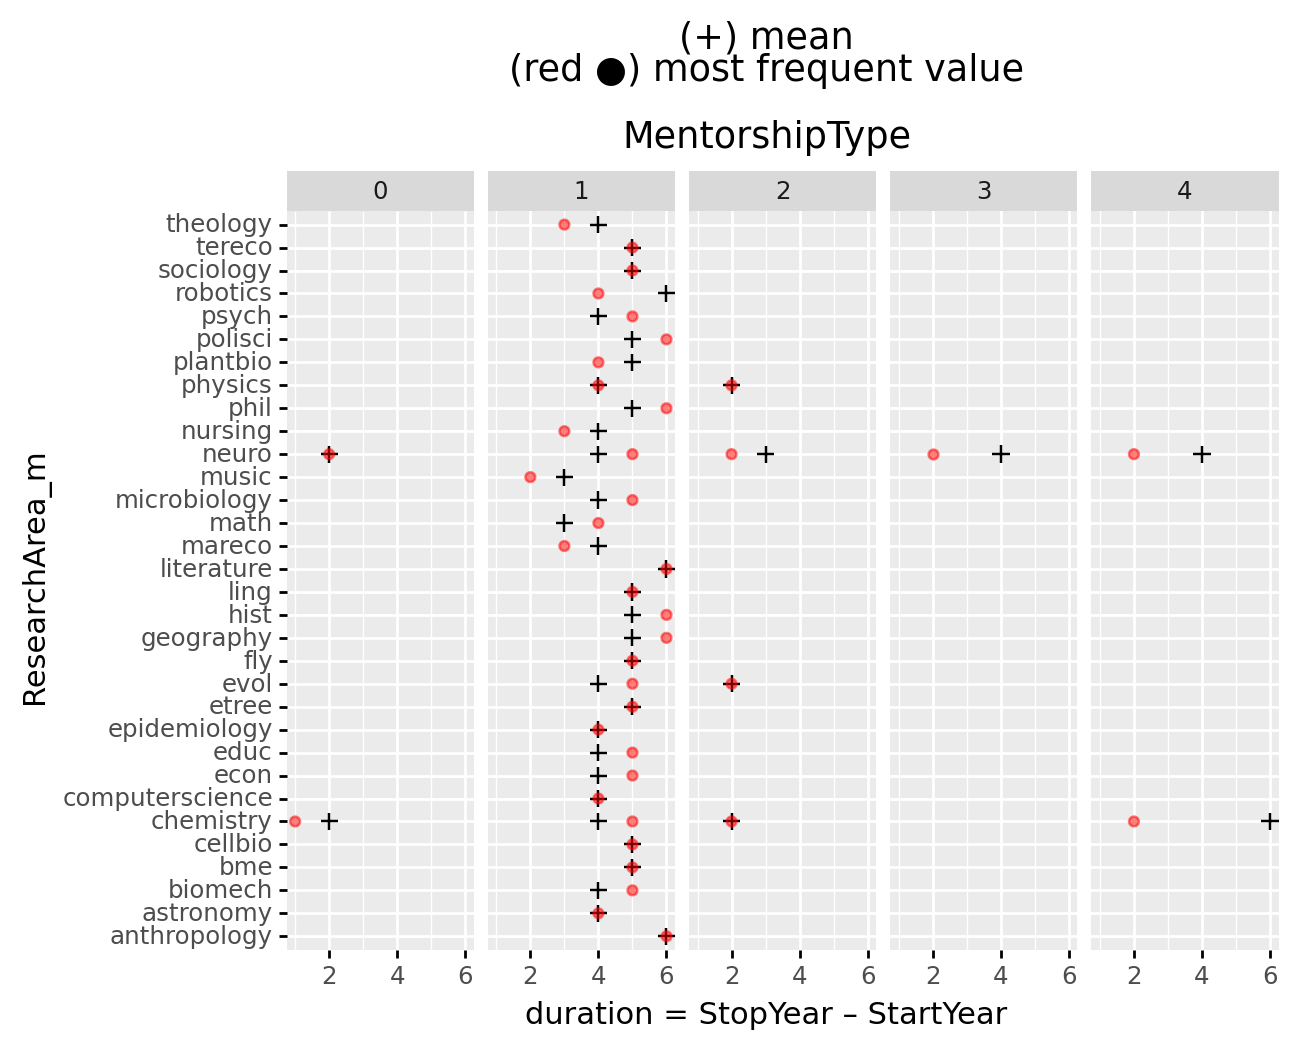

In [9]:
(ggplot(aes(x='ResearchArea_m'), data=quick_look.loc[quick_look['n'] > 2000]) + 
 geom_point(aes(y='mean_group_duration'), shape="+", size=3) +  
 geom_point(aes(y='mfv_group_duration'), color="red", alpha = 0.5) + 
 coord_flip() + facet_wrap("MentorshipType", ncol = 5) + 
 labs(title = "(+) mean\n(red ●) most frequent value\n\nMentorshipType", 
      y = "duration = StopYear – StartYear")).draw();